In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
data = pd.read_csv('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv',low_memory=False)
data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

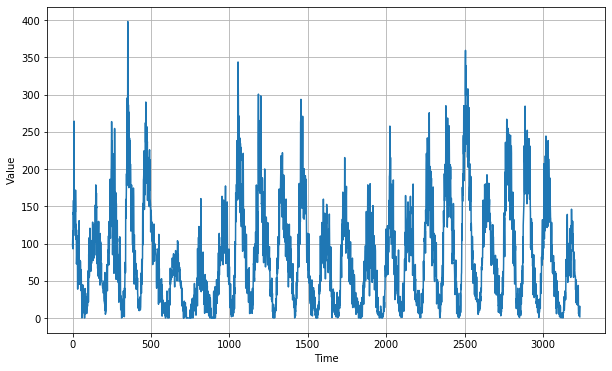

In [13]:
series = np.array(data['Monthly Mean Total Sunspot Number'])
time = np.array(data['Unnamed: 0'])

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [14]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 15s 1s/step - loss: 80.2708 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 6s 492ms/step - loss: 78.2509 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 7s 575ms/step - loss: 75.6613 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 6s 508ms/step - loss: 72.3021 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 6s 475ms/step - loss: 69.0173 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 6s 462ms/step - loss: 65.3797 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 5s 457ms/step - loss: 61.9061 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 6s 493ms/step - loss: 58.0653 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 7s 577ms/step - loss: 55.4543 - mae: 55.5682
Epoch 10/100
12/12

12/12 [==============================] - 8s 626ms/step - loss: 21.1145 - mae: 21.5573
Epoch 83/100
12/12 [==============================] - 8s 639ms/step - loss: 22.9178 - mae: 23.5180
Epoch 84/100
12/12 [==============================] - 7s 604ms/step - loss: 30.0394 - mae: 29.9236
Epoch 85/100
12/12 [==============================] - 7s 560ms/step - loss: 35.4676 - mae: 36.0585
Epoch 86/100
12/12 [==============================] - 7s 576ms/step - loss: 40.0692 - mae: 40.4880
Epoch 87/100
12/12 [==============================] - 7s 603ms/step - loss: 47.3542 - mae: 47.6771
Epoch 88/100
12/12 [==============================] - 8s 632ms/step - loss: 34.9805 - mae: 34.9862
Epoch 89/100
12/12 [==============================] - 7s 591ms/step - loss: 33.8389 - mae: 34.4337
Epoch 90/100
12/12 [==============================] - 7s 554ms/step - loss: 33.0672 - mae: 33.7040
Epoch 91/100
12/12 [==============================] - 6s 517ms/step - loss: 31.0804 - mae: 31.2495
Epoch 92/100
12/12 [===

[1e-08, 0.0001, 0, 60]

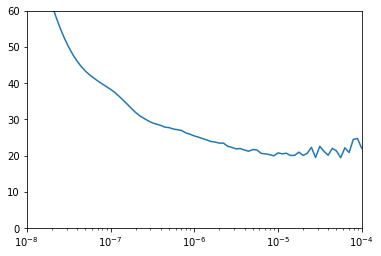

In [18]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=400)

Epoch 1/400
30/30 [==============================] - 18s 615ms/step - loss: 37.8969 - mae: 38.6062
Epoch 2/400
30/30 [==============================] - 11s 375ms/step - loss: 24.0752 - mae: 24.6120
Epoch 3/400
30/30 [==============================] - 12s 383ms/step - loss: 22.0254 - mae: 22.5216
Epoch 4/400
30/30 [==============================] - 11s 383ms/step - loss: 19.8230 - mae: 20.3070
Epoch 5/400
30/30 [==============================] - 11s 376ms/step - loss: 19.4551 - mae: 19.9427
Epoch 6/400
30/30 [==============================] - 11s 359ms/step - loss: 19.2165 - mae: 19.7132
Epoch 7/400
30/30 [==============================] - 11s 376ms/step - loss: 18.6321 - mae: 19.1041
Epoch 8/400
30/30 [==============================] - 11s 377ms/step - loss: 18.4248 - mae: 18.9368
Epoch 9/400
30/30 [==============================] - 11s 370ms/step - loss: 18.2323 - mae: 18.6858
Epoch 10/400
30/30 [==============================] - 11s 379ms/step - loss: 18.5262 - mae: 18.9543
Epoch 11/

30/30 [==============================] - 8s 265ms/step - loss: 16.4166 - mae: 16.8846
Epoch 84/400
30/30 [==============================] - 8s 252ms/step - loss: 16.3686 - mae: 16.8496
Epoch 85/400
30/30 [==============================] - 8s 261ms/step - loss: 16.3524 - mae: 16.8358
Epoch 86/400
30/30 [==============================] - 9s 285ms/step - loss: 16.3319 - mae: 16.8101
Epoch 87/400
30/30 [==============================] - 8s 283ms/step - loss: 16.3547 - mae: 16.8284
Epoch 88/400
30/30 [==============================] - 8s 274ms/step - loss: 16.7918 - mae: 17.2445
Epoch 89/400
30/30 [==============================] - 7s 245ms/step - loss: 16.6408 - mae: 17.1338
Epoch 90/400
30/30 [==============================] - 7s 250ms/step - loss: 16.2864 - mae: 16.7854
Epoch 91/400
30/30 [==============================] - 8s 261ms/step - loss: 16.3372 - mae: 16.8224
Epoch 92/400
30/30 [==============================] - 8s 282ms/step - loss: 16.3182 - mae: 16.7900
Epoch 93/400
30/30 [===

30/30 [==============================] - 12s 390ms/step - loss: 15.9638 - mae: 16.4369
Epoch 165/400
30/30 [==============================] - 12s 386ms/step - loss: 15.8453 - mae: 16.3075
Epoch 166/400
30/30 [==============================] - 12s 389ms/step - loss: 15.8893 - mae: 16.3835
Epoch 167/400
30/30 [==============================] - 12s 391ms/step - loss: 15.9414 - mae: 16.4302
Epoch 168/400
30/30 [==============================] - 12s 389ms/step - loss: 15.8379 - mae: 16.3010
Epoch 169/400
30/30 [==============================] - 12s 384ms/step - loss: 15.8920 - mae: 16.3699
Epoch 170/400
30/30 [==============================] - 12s 388ms/step - loss: 15.7697 - mae: 16.2628
Epoch 171/400
30/30 [==============================] - 12s 390ms/step - loss: 15.8037 - mae: 16.2853
Epoch 172/400
30/30 [==============================] - 12s 386ms/step - loss: 15.7345 - mae: 16.2170
Epoch 173/400
30/30 [==============================] - 11s 380ms/step - loss: 15.8115 - mae: 16.3110
Epoc

30/30 [==============================] - 12s 391ms/step - loss: 15.3570 - mae: 15.8275
Epoch 246/400
30/30 [==============================] - 12s 393ms/step - loss: 15.9696 - mae: 16.5002
Epoch 247/400
30/30 [==============================] - 12s 391ms/step - loss: 15.5794 - mae: 16.1096
Epoch 248/400
30/30 [==============================] - 12s 391ms/step - loss: 15.5332 - mae: 16.0106
Epoch 249/400
30/30 [==============================] - 12s 390ms/step - loss: 15.3517 - mae: 15.8151
Epoch 250/400
30/30 [==============================] - 12s 394ms/step - loss: 15.3878 - mae: 15.8813
Epoch 251/400
30/30 [==============================] - 12s 391ms/step - loss: 15.2217 - mae: 15.7383
Epoch 252/400
30/30 [==============================] - 12s 387ms/step - loss: 15.2918 - mae: 15.7940
Epoch 253/400
30/30 [==============================] - 12s 386ms/step - loss: 15.2505 - mae: 15.7393
Epoch 254/400
30/30 [==============================] - 12s 388ms/step - loss: 15.3114 - mae: 15.7919
Epoc

30/30 [==============================] - 11s 379ms/step - loss: 14.8639 - mae: 15.3405
Epoch 327/400
30/30 [==============================] - 11s 372ms/step - loss: 14.9600 - mae: 15.4506
Epoch 328/400
30/30 [==============================] - 11s 377ms/step - loss: 14.9164 - mae: 15.4100
Epoch 329/400
30/30 [==============================] - 11s 377ms/step - loss: 15.0335 - mae: 15.5123
Epoch 330/400
30/30 [==============================] - 11s 378ms/step - loss: 14.9295 - mae: 15.4234
Epoch 331/400
30/30 [==============================] - 11s 373ms/step - loss: 14.9287 - mae: 15.4293
Epoch 332/400
30/30 [==============================] - 11s 353ms/step - loss: 14.9196 - mae: 15.4156
Epoch 333/400
30/30 [==============================] - 11s 376ms/step - loss: 14.9570 - mae: 15.4519
Epoch 334/400
30/30 [==============================] - 11s 358ms/step - loss: 14.8693 - mae: 15.3376
Epoch 335/400
30/30 [==============================] - 11s 371ms/step - loss: 14.9526 - mae: 15.4567
Epoc

In [22]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

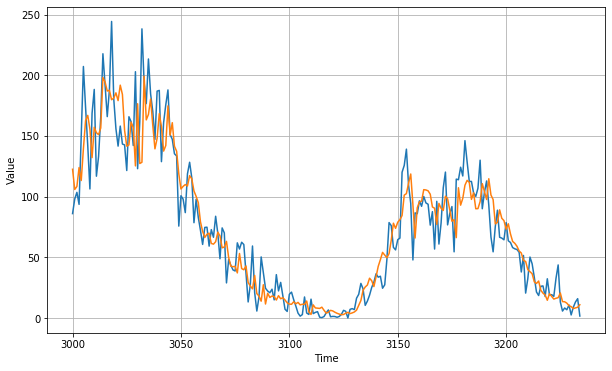

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.686015

<Figure size 432x288 with 0 Axes>

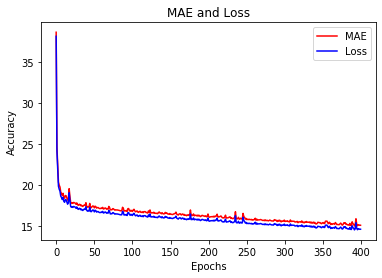

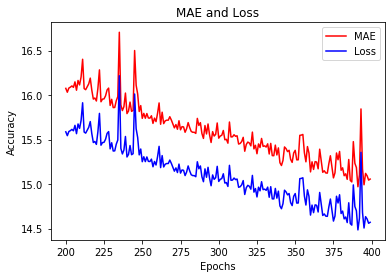

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()